In [1]:
import numpy as np
import Labber
import matplotlib.pyplot as plt
from lambda_system import *
import lmfit as lm
from matplotlib import cm

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics}')
plt.rc('font', **{'family':'sans-serif'} )

In [2]:
# If Labber not available replace with numpy data files

fin1 = r'..\Data\Fig1 Data\Find 3Q Gate Fine c1 freq.hdf5'
fin2 = r'..\Data\Fig1 Data\Find 3Q Gate Fine c2 freq.hdf5'
log1 = Labber.LogFile(fin1)
log2 = Labber.LogFile(fin2)

data1 = log1.getData('Pointer States - Average state vector')
data1 = np.reshape(data1, (61, 101, -1))
# data1 = np.reshape(data1, (151, 101, -1))

data2 = log2.getData('Pointer States - Average state vector')
data2 = np.reshape(data2, (51, 101, -1))

In [3]:
print(data1.shape)
print(data2.shape)

(61, 101, 27)
(51, 101, 27)


In [4]:
t = np.linspace(0, 1, 101)

fc1 = np.linspace(-3, 3, 61)
# fc1 = np.linspace(0, 7.5, 151) - 7.5/2
fc2 = np.linspace(-2.5, 2.5, 51)
# X, Y = np.meshgrid(t, fc1)
X, Y = np.meshgrid(t, fc2)
z = data1[:, :, 10]

z_data_full = np.array([data2[:, :, 4], data2[:,:,2], data2[:,:,10]])

print(z_data_full.shape)
print(z_data_full.flatten().shape)

(3, 51, 101)
(15453,)


In [5]:
def landscape_2d(X, d1, Y, g1, g2, A1, A2, A3, tau, t0):
# def landscape_2d(X, Y, d2, g1, g2, A1, A2, A3, tau, t0):
    d1_rad = 2 * np.pi * d1
    d2_rad = 2 * np.pi * Y

    g1_rad = 2 * np.pi * g1
    g2_rad = 2 * np.pi * g2

    in1 = 1
    in2 = 0
    in3 = 0

    pop1 = lambda_system.P1(X, t0, d1_rad, d2_rad, g1_rad, g2_rad, in1, in2, in3)
    pop2 = lambda_system.P2(X, t0, d1_rad, d2_rad, g1_rad, g2_rad, in1, in2, in3)
    pop3 = lambda_system.P3(X, t0, d1_rad, d2_rad, g1_rad, g2_rad, in1, in2, in3)

    r1 = A1*pop1*np.exp(-X/tau)
    r2 = A2*pop2*np.exp(-X/tau)
    r3 = A3*pop3*np.exp(-X/tau)

    return r1, r2, r3

def landscape_dataset(params, X, Y):
    d1 = params['d1'].value
    # d2 = params['d2'].value
    g1 = params['g1'].value
    g2 = params['g2'].value
    A1 = params['A1'].value
    A2 = params['A2'].value
    A3 = params['A3'].value
    tau = params['tau'].value
    t0 = params['t0'].value

    # r1, r2, r3 = landscape_2d(X, Y, d2, g1, g2, A1, A2, A3, tau, t0)
    r1, r2, r3 = landscape_2d(X, d1, Y, g1, g2, A1, A2, A3, tau, t0)
    return np.array([r1, r2, r3])

def objective(params, X, Y, data):
    resid = np.zeros(data.shape)

    landscape = landscape_dataset(params, X, Y)
    for i in range(3):
        resid[i, :, :] = np.real(data[i, :, :] - landscape[i, :, :])
    return resid.flatten()
    

params = lm.Parameters()



In [6]:
params.add('d2', value=0.019, min=-5, max=5, vary=True)
params.add('d1', value=0.12, min=-5, max=5, vary=True)
params.add('g1', value=1.6, min=0, max=5, vary=True)
params.add('g2', value=1.6, min=0, max=5, vary=True)
params.add('A1', value=0.8, min=0, max=1, vary=True)
params.add('A2', value=0.8, min=0, max=1)
params.add('A3', value=0.8, min=0, max=1, vary=True)
params.add('tau', value=7, min=0, max=10, vary=True)
params.add('t0', value=-0.02, min=-0.1, max=0.015, vary=True)

In [7]:
# res = model.fit(z, X=X, Y=Y, params=params)
res = lm.minimize(objective, params, args=(X, Y, z_data_full))

print(lm.fit_report(res))


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 15453
    # variables        = 3
    chi-square         = 82.7358541
    reduced chi-square = 0.00535507
    Akaike info crit   = -80811.7279
    Bayesian info crit = -80788.7913
[[Variables]]
    d1:  -0.23316841 +/- 0.00347328 (1.49%) (init = 0)
    g1:   1.57252225 +/- 7.9274e-04 (0.05%) (init = 1.62)
    g2:   1.62 (fixed)
    A1:   0.85 (fixed)
    A2:   0.69410423 +/- 0.00316864 (0.46%) (init = 0.88)
    A3:   0.8 (fixed)
    tau:  7 (fixed)
    t0:  -0.02 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(d1, g1) =  0.201


(3, 51, 101)


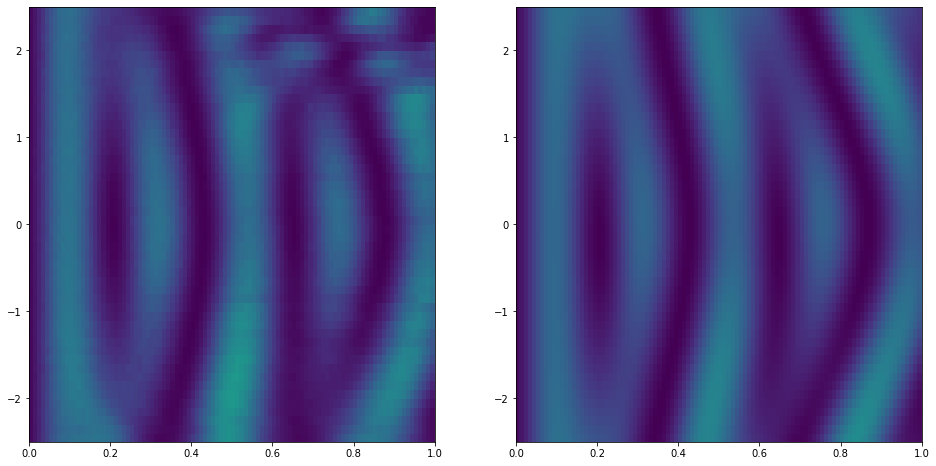

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

fit = landscape_dataset(res.params, X, Y)
print(fit.shape)

idx = 1

axs[0].pcolor(X, Y, z_data_full[idx, :, :], vmin=0, vmax=1)
axs[1].pcolor(X, Y, np.real(fit[idx, :, :]), vmin=0, vmax=1)


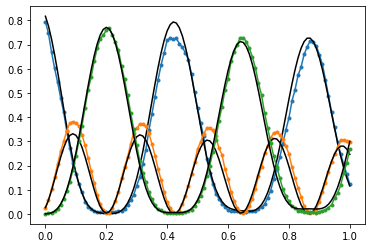

In [9]:
for i in range(3):
    plt.plot(t, z_data_full[i, 25, :], '.-')
    plt.plot(t, np.real(fit[i, 25, :]), '-k')

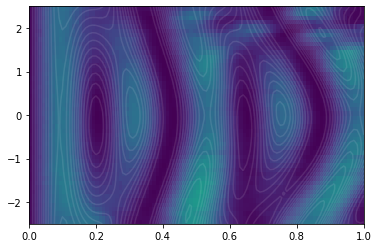

In [10]:
plt.pcolor(X, Y, z_data_full[idx, :, :], vmin=0, vmax=1)
plt.contour(X, Y, np.real(fit[idx, :, :]), levels=15, vmin=0, vmax=1, colors='white', alpha=0.1)

In [11]:
t = np.linspace(0, 1, 101)
z_slice = z_data_full[:, 25, :]

In [12]:
def landscape_slice(t, d1, d2, g1, g2, A1, A2, A3, tau, t0):
    d1_rad = 2 * np.pi * d1
    d2_rad = 2 * np.pi * d2

    g1_rad = 2 * np.pi * g1
    g2_rad = 2 * np.pi * g2

    in1 = 1
    in2 = 0
    in3 = 0

    pop1 = lambda_system.P1(t, t0, d1_rad, d2_rad, g1_rad, g2_rad, in1, in2, in3)
    pop2 = lambda_system.P2(t, t0, d1_rad, d2_rad, g1_rad, g2_rad, in1, in2, in3)
    pop3 = lambda_system.P3(t, t0, d1_rad, d2_rad, g1_rad, g2_rad, in1, in2, in3)

    r1 = A1*pop1*np.exp(-t/tau)
    r2 = A2*pop2*np.exp(-t/tau)
    r3 = A3*pop3*np.exp(-t/tau)

    return r1, r2, r3

def landscape_dataset(params, t):
    d1 = params['d1'].value
    d2 = params['d2'].value
    g1 = params['g1'].value
    g2 = params['g2'].value
    A1 = params['A1'].value
    A2 = params['A2'].value
    A3 = params['A3'].value
    tau = params['tau'].value
    t0 = params['t0'].value

    r1, r2, r3 = landscape_2d(t, d1, d2, g1, g2, A1, A2, A3, tau, t0)
    return np.array([r1, r2, r3])

def objective(params, t, data, idx):
    resid = np.zeros(data.shape)

    landscape = landscape_dataset(params, t)
    for i in range(3):
        resid[i, :, :] = np.real(data[i, idx, :] - landscape[i, :])
    return resid.flatten()
    


In [23]:
params = lm.Parameters()
params.add('d1', value=0.01, min=-5, max=5, vary=True)
params.add('d2', value=0.01, min=-5, max=5, vary=True)
params.add('g1', value=1.62, min=0, max=5, vary=True)
params.add('g2', value=1.62, min=0, max=5, vary=True)
params.add('A1', value=0.85, min=0, max=1, vary=True)
params.add('A2', value=0.88, min=0, max=1)
params.add('A3', value=0.8, min=0, max=1, vary=True)
params.add('tau', value=7, min=0, max=10, vary=True)
params.add('t0', value=-0.02, min=-0.1, max=0.015, vary=True)


# params['g1'].expr = 'g2'



idx=26

res = lm.minimize(objective, params, args=(t, z_data_full, idx))
print(lm.fit_report(res))

fit = landscape_dataset(res.params, t)
print(fit.shape)



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 15453
    # variables        = 9
    chi-square         = 0.97763180
    reduced chi-square = 6.3302e-05
    Akaike info crit   = -149384.395
    Bayesian info crit = -149315.585
[[Variables]]
    d1:   0.12643469 +/- 0.00269245 (2.13%) (init = 0.01)
    d2:   0.01932324 +/- 0.00352719 (18.25%) (init = 0.01)
    g1:   1.58793977 +/- 4.6215e-04 (0.03%) (init = 1.62)
    g2:   1.60489283 +/- 4.5314e-04 (0.03%) (init = 1.62)
    A1:   0.79737548 +/- 3.8672e-04 (0.05%) (init = 0.85)
    A2:   0.76495340 +/- 6.5582e-04 (0.09%) (init = 0.88)
    A3:   0.79067784 +/- 3.4232e-04 (0.04%) (init = 0.8)
    tau:  7.34149378 +/- 0.04049887 (0.55%) (init = 7)
    t0:  -0.01760978 +/- 3.1908e-05 (0.18%) (init = -0.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(g1, g2)  = -0.922
    C(g1, A2)  = -0.692
    C(g2, A2)  =  0.668
    C(d1, d2)  = -0.659
    C(A3, tau) = -0.654
    C(A

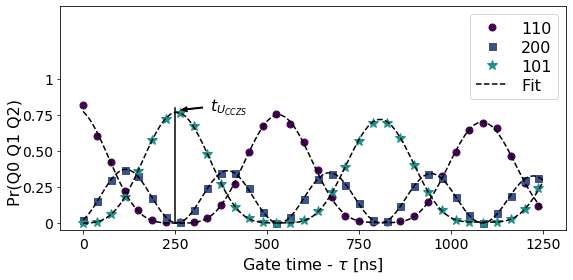

In [25]:
colors = cm.viridis(np.linspace(0, 1, 5))
labels = [r'110', r'200', r'101']
markers = ['o', 's', '*']

fig, ax = plt.subplots(figsize=(8,4))
for i in range(3):
    if i==2:
        size = 10
    else:
        size=7
    plt.plot(t[::3]*1000, z_data_full[i, idx, ::3], label=labels[i], marker=markers[i], linestyle='None', color=colors[i], markersize=size)
    # plt.errorbar(t[::2]*1000, z_data_full[i, idx, ::2], yerr=0.0036, label=labels[i], marker='.', linestyle='None', color=colors[i], markersize=12)

plt.plot(t[:]*1000, np.real(fit[0, :]), '--k', label=r'Fit')
plt.plot(t[:]*1000, np.real(fit[1, :]), '--k')
plt.plot(t[:]*1000, np.real(fit[2, :]), '--k')

plt.plot([200]*2, [0, 0.8], 'k')

# plt.plot([202]*2, [0,0.775], '-k')
plt.annotate(r'$t_{U_{CCZS}}$', xy=(202, 0.78), xytext=(275, 0.78), fontsize=16, arrowprops=dict(facecolor='k', width=1, headwidth=5, shrink=0.15, headlength=6))
# plt.text(275, 0.8, r'$t_{U_{CCZS}}$', fontsize=16)

plt.xticks([0, 200, 400, 600, 800, 1000], fontsize=14, labels=['0', '250', '500', '750', '1000', '1250'])
plt.xlabel(r'Gate time - $\tau$ [ns]', fontsize=16)
plt.yticks([0,0.25, 0.5, 0.75, 1], fontsize=14, labels=['0', '0.25', '0.50', '0.75', '1'])
plt.ylim([-0.05, 1.5])
plt.ylabel(r'Pr(Q0 Q1 Q2)', fontsize=16)
ax.yaxis.set_label_coords(-0.075, 0.35)



# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=4, fontsize=14, handletextpad=0.25)
plt.legend(fontsize=16, labelspacing=0.25)
plt.tight_layout()
plt.savefig(r'PopTransferLinecut.pdf', dpi=400)
